# Dependence

In [243]:
import torch
import torch.nn as nn
import torch.autograd as autograd

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.tri as mtri

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameter

In [244]:
steps = 10000
layers = np.array([2,32,64,32,2])
lr = 0.001

# Build mesh

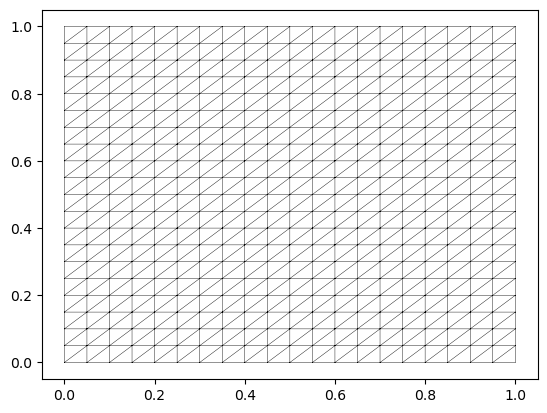

In [245]:
m_rows = 20
m_cols = 20

x = torch.linspace(0, 1, m_cols + 1)
y = torch.linspace(0, 1, m_rows + 1)
x = x.repeat(m_rows + 1)
y = y.repeat_interleave(m_cols + 1)
Vc = torch.stack([x,y],dim=1)

tris = []

for i in range(m_cols):
   for j in range(m_rows):
       tris.append([j * (m_cols + 1) + i, j * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i + 1])
       tris.append([j * (m_cols + 1) + i, (j + 1) * (m_cols + 1) + i + 1, (j + 1) * (m_cols + 1) + i])
        
tris = torch.tensor(tris)

#boundarys = V[(V[:,0]==0.0) | (V[:,1]==0.0) | (V[:,0]==1.0) | (V[:,1]==1.0)]
left_boundarys = Vc[(Vc[:,0]==0.0)]
bottom_boundarys = Vc[(Vc[:,1]==0.0)]
top_boundarys = Vc[(Vc[:,1]==1.0)]
right_boundarys = Vc[(Vc[:,0]==1.0)]

plt.triplot(x,y,tris,'k-',linewidth=0.3)
plt.show()

# Moving Mesh Functions

In [246]:
def U(V):
    return torch.tanh(-30*(V[:,1]-0.5-0.25*torch.sin(2*torch.pi*V[:,0])))

def U_x_y(V):
    U_x = (1-U(V)**2)*(15*torch.pi*torch.cos(2*torch.pi*V[:,0]))
    U_y = (1-U(V)**2)*(-30)
    return torch.stack([U_x,U_y],dim=1)

def metric(V):
    u_x_y = U_x_y(V)
    uxy_norm = 0.1 * torch.linalg.norm(u_x_y,dim=1)**2 + 1
    return torch.diag_embed(uxy_norm.unsqueeze(-1).expand(-1,2),dim1=-2,dim2=-1)
    
    
# def metric(V):
#     u_x_y = U_x_y(V)
#     col = u_x_y.unsqueeze(2)
#     row = u_x_y.unsqueeze(1)
#     u_x_y_2 = col@row
#     u_x_y_2[:,0,0] += 1
#     u_x_y_2[:,1,1] += 1
#     return u_x_y_2
#     eigenvalues, eigenvectors = torch.linalg.eigh(u_x_y_2)
#     sqrt_eigenvalues = torch.sqrt(eigenvalues)
#     return eigenvectors @ torch.diag_embed(sqrt_eigenvalues) @ eigenvectors.transpose(1,2)

# Auxiliary Functions


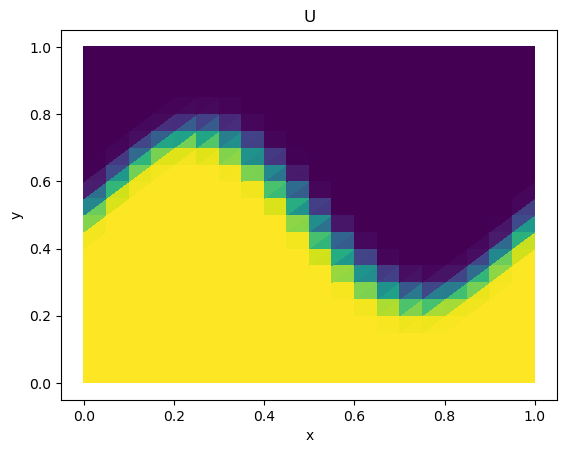

In [247]:
def area(V,tris):
    v1,v2,v3 = V[tris[:,0]],V[tris[:,1]],V[tris[:,2]]
    return 0.5*torch.abs((v2[:,0]-v1[:,0])*(v3[:,1]-v1[:,1])-(v3[:,0]-v1[:,0])*(v2[:,1]-v1[:,1]))
    
def centroid(V,tris):
    return (V[tris[:,0]]+V[tris[:,1]]+V[tris[:,2]])/3.0

def Plot(V, U):
    _,ax=plt.subplots()
    ax.tripcolor(V[:,0],V[:,1],tris,U,cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('U')
    plt.show()
    
Plot(Vc,U(Vc))

# Neural Network

In [ ]:
class FCN(nn.Module):
    def __init__(self,layers):
        super().__init__()
        self.layers = layers 
        self.activation = nn.Tanh()
        self.loss_function = nn.MSELoss(reduction ='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)]) 
        self.iter = 0
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)   

    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        a = x.float()
        for i in range(len(self.layers)-2):  
            z = self.linears[i](a)              
            a = self.activation(z)
        a = self.linears[-1](a)
        return a    
    
    def jacobian(self,V):
        V.requires_grad = True
        xy = self.forward(V)
        x = xy[:,0].unsqueeze(1)
        y = xy[:,1].unsqueeze(1)
        dx = autograd.grad(x,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        dy = autograd.grad(y,V,torch.ones([V.shape[0],1]).to(device),retain_graph=True,create_graph=True)[0]
        return torch.stack([dx,dy],dim=1)
    
    def loss_BC(self,BC):
        return self.loss_function(self.forward(BC[0,:,:2])[:,0],BC[0,:,2]) + \
               self.loss_function(self.forward(BC[1,:,:2])[:,0],BC[1,:,2]) + \
               self.loss_function(self.forward(BC[2,:,:2])[:,1],BC[2,:,2]) + \
               self.loss_function(self.forward(BC[3,:,:2])[:,1],BC[3,:,2])
    
    def loss_G(self,V_ref,tris):
        areas = area(V_ref,tris)
        centroids = centroid(V_ref,tris)
        #cx = self.forward(centroids)
        Vc = self.forward(V_ref)
        cx = centroid(Vc,tris)
        J = self.jacobian(centroids)
        detJ = torch.linalg.det(J)
        Jinv = torch.linalg.inv(J)
        JinvT = Jinv.transpose(1,2)
        M = metric(cx)
        M_inv = torch.linalg.inv(M)
        JMJ = Jinv@M_inv@JinvT
        traces = JMJ[:,0,0] + JMJ[:,1,1]  
        return self.loss_function(torch.sum(areas*traces*detJ),torch.tensor(0.0).to(device))

    def loss(self,Vc,tris,BC):      
        return self.loss_G(Vc,tris) + self.loss_BC(BC)
        
        # V.requires_grad = True
        # V_ref.requires_grad = True
        # J = self.jacobian(V_ref,V,tris)
        # JT = J.transpose(1,2)
        # vol = self.area(V,tris)
        # JJT = torch.bmm(J,JT)
        # traces = JJT[:,0,0] + JJT[:,1,1]
        # return torch.dot(vol, traces)

# Train Neural Network

C:\Users\13162\AppData\Local\Temp\ipykernel_33448\2455172087.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tris = torch.tensor(tris,dtype=torch.long).to(device)


0 0.8956578
1 0.62434727
2 0.40625045
3 0.24165417
4 0.12930803
5 0.06545731
6 0.042685404
7 0.04941275
8 0.07132887
9 0.094894156
10 0.11076886
11 0.11497325
12 0.10791246
13 0.09261343
14 0.073117755
15 0.053337466
16 0.036356606
17 0.024088312
18 0.01721029
19 0.015316973
20 0.017222457
21 0.021335004
22 0.026021147
23 0.029896535
24 0.032010112
25 0.031919174
26 0.029670216
27 0.02570813
28 0.02073669
29 0.015556257
30 0.0109055955
31 0.0073342063
32 0.0051253103
33 0.0042798147
34 0.0045576203
35 0.0055598817
36 0.0068289833
37 0.007944048
38 0.008595545
39 0.008629035
40 0.008053672
41 0.007015867
42 0.005745722
43 0.0044906046
44 0.0034537204
45 0.0027537746
46 0.0024132514
47 0.0023730886
48 0.0025235503
49 0.0027389987
50 0.0029074016
51 0.0029506632
52 0.0028350516
53 0.0025723046
54 0.0022115817
55 0.0018237059
56 0.0014808382
57 0.0012371904
58 0.0011164728
59 0.0011095521
60 0.0011816041
61 0.0012850598
62 0.0013733635
63 0.0014118962
64 0.0013842979
65 0.0012939328
66 0.0

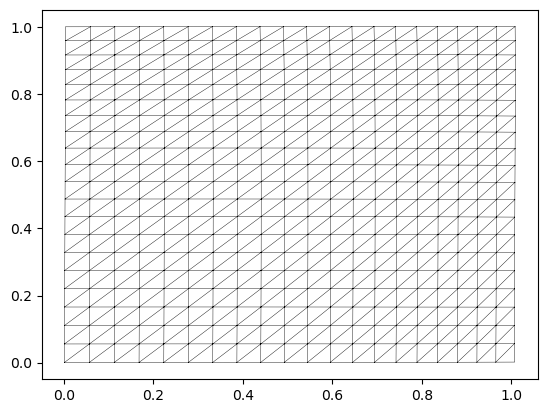

In [249]:
Vc = Vc.float().to(device)
tris = torch.tensor(tris,dtype=torch.long).to(device)

BC1 = torch.cat((left_boundarys,torch.zeros(left_boundarys.shape[0],1)),dim=1)
BC2 = torch.cat((right_boundarys,torch.ones(right_boundarys.shape[0],1)),dim=1)
BC3 = torch.cat((bottom_boundarys,torch.zeros(bottom_boundarys.shape[0],1)),dim=1)
BC4 = torch.cat((top_boundarys,torch.ones(top_boundarys.shape[0],1)),dim=1)
BC = torch.stack((BC1,BC2,BC3,BC4),dim=0).to(device)

MMPDE_Net = FCN(layers)
MMPDE_Net.to(device)
params = list(MMPDE_Net.parameters())
optimizer = torch.optim.Adam(MMPDE_Net.parameters(),lr=lr,amsgrad=False)

for i in range(steps):
    loss = MMPDE_Net.loss(Vc,tris,BC)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(i,loss.detach().cpu().numpy())
    
new_V = MMPDE_Net(Vc).detach().cpu()
plt.triplot(new_V[:,0],new_V[:,1],tris.detach().cpu(),'k-',linewidth=0.3)